# Spotify Extended History

The following notebook is an experimental exploration of Spotify's **Extended History**.
The data is requested from Spotify and contains every individual play (by my account) from **October 2015** until **March 2023**.

In [113]:
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
import tqdm
import ipywidgets
from IPython.display import Markdown, display

In [43]:
df = pd.concat(map(pd.read_json, ["data/endsong_0.json", "data/endsong_1.json", "data/endsong_2.json", "data/endsong_3.json", "data/endsong_4.json", "data/endsong_5.json"]))
df.iloc[[0,-1]]

,ts,username,platform,ms_played,conn_country,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,...,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2015-10-04T17:25:52Z,thatollom,"Android OS 4.4.2 API 19 (THL, thl 5000)",121393,DE,95.91.224.1,unknown,Play Hard (feat. Ne-Yo & Akon),David Guetta,Nothing but the Beat,...,NaN,NaN,NaN,clickrow,endplay,False,1.0,False,0,False
6038,2023-05-14T22:12:55Z,thatollom,ios,154381,DE,37.4.229.9,unknown,Dawn of the Dragonstar,Twilight Force,Dawn of the Dragonstar,...,None,None,None,trackdone,endplay,False,1.0,False,1684074699,False


In [44]:
df.drop(columns=["username", "ip_addr_decrypted", "user_agent_decrypted", "offline_timestamp", "incognito_mode"], inplace=True)

In [45]:
df["ts"] = pd.to_datetime(df["ts"])
original_length = len(df)

In [120]:
unique_tracks = df_orig["master_metadata_track_name"].unique()
print(len(unique_tracks), "unique tracks have been played")

19682 unique tracks have been played


---
**Data:**
- `df` All columns; Only songs that have been played at least 10 times.
- `df_orig` All columns.
- `unique_tracks` Every track played.

**Edit:**
Upon further inspection, the 2015 data appear to be characterisec by irregular usage and a general lack of significance and thus will be excluded from the dataset.

In [46]:
df_top_tracks = df["master_metadata_track_name"].value_counts().to_frame()
df_top_tracks = df_top_tracks.reset_index().rename(columns={"index":"name","master_metadata_track_name":"plays"})
top_names = df_top_tracks[df_top_tracks["plays"]>=10]["name"]
df_orig = df
df = df[df["master_metadata_track_name"].isin(top_names)].reset_index(drop=True)
# Edit:
df = df[df["ts"].dt.year != 2015]

print("original length:", original_length)
print(" reduced length:", len(df))
print("      reduction:", str(round(len(df)/original_length*100,2))+"%")

original length: 86032
 reduced length: 44745
      reduction: 52.01%


<div class="alert alert-block alert-success"> 
    It could be useful to further only include tracks,
    that have been played at lead 30% (or 50%) of their length. <br>
    Including skipped tracks carries the risk of further distorting the real hearing-bahavior.

</div>

In [47]:
num_skipped = len(df_orig[df_orig["skipped"] == 1])
print(round(num_skipped/len(df_orig)*100,2), "% of tracks have been skipped.") 

3.12 % of tracks have been skipped.


Though only a small percentage of tracks have been skipped, it is unlikeley, that the remaining tracks have been played to the end.


<AxesSubplot:xlabel='count', ylabel='reason_end'>

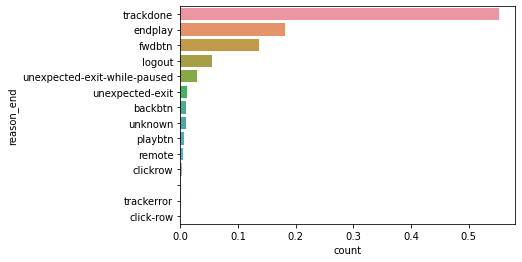

In [107]:
reason_end_count = df_orig["reason_end"].value_counts(normalize=True).to_frame().reset_index().rename({"index":"reason_end", "reason_end":"count"}, axis=1)
sns.barplot(data=reason_end_count, x="count", y="reason_end")

---
Songs played per year.

(only skipped excluded)

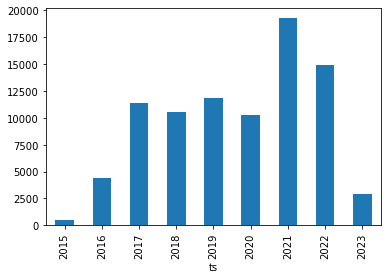

In [49]:
df_orig.groupby(df_orig["ts"].dt.year)["ts"].count().plot(kind="bar")
plt.show()

---
Songs per year per quarter.

<AxesSubplot:xlabel='ts'>

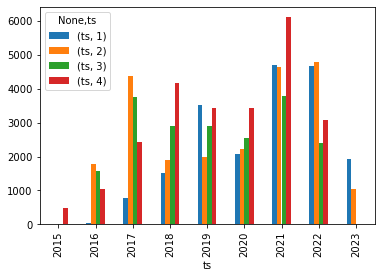

In [50]:
df_my = df_orig.groupby([df_orig["ts"].dt.year, df_orig["ts"].dt.quarter])["ts"].agg("count").to_frame()
df_my.index.sortlevel(0, sort_remaining=True)
df_my.unstack().plot(kind="bar", stacked=False)

---
Finding the longes heared tracks.

In [57]:
##### config ######
calculate = False
###################

if calculate:
    df_playcount = df["master_metadata_track_name"].value_counts().to_frame()
    df_from_to = pd.DataFrame(columns=["track_name", "plays", "first_played", "last_played", "days_between", "days_played"])

    for song, plays in tqdm.notebook.tqdm(df_playcount.iterrows(), total=df_playcount.shape[0]):
        first_ts = df[df["master_metadata_track_name"] == song].iloc[0]["ts"]
        last_ts = df[df["master_metadata_track_name"] == song].iloc[-1]["ts"]

        df_ts = df.set_index("ts")
        df_ts_filtered = df_ts[df_ts["master_metadata_track_name"] == song]
        days_played = len(df_ts_filtered.groupby(df_ts_filtered.index.date).count())

        row = {
            "track_name": song,
            "plays": plays.values[0],
            "first_played": first_ts,
            "last_played": last_ts,
            "days_between": (last_ts - first_ts).days,
            "days_played": days_played,
        }
        new_df = pd.DataFrame([row])
        df_from_to = pd.concat([df_from_to, new_df], ignore_index=True)

    df_from_to.to_csv("df_from_to.csv")
else:
    df_from_to = pd.read_csv("df_from_to.csv")

df_from_to

,Unnamed: 0,track_name,plays,first_played,last_played,days_between,days_played
0,0,T-Shirt Song,201,2018-01-14 21:02:25+00:00,2022-09-23 16:51:53+00:00,1712,92
1,1,Punk Rock Songs,195,2021-11-08 05:54:24+00:00,2023-04-24 09:46:14+00:00,532,128
2,2,Nothing,194,2021-10-13 12:28:43+00:00,2023-05-11 17:40:42+00:00,575,100
3,3,"Young, Wild & Free (feat. Bruno Mars)",182,2016-01-24 11:15:06+00:00,2022-02-17 15:23:58+00:00,2216,89
4,4,Young as the Morning Old as the Sea,179,2016-10-09 10:48:16+00:00,2021-11-23 14:41:52+00:00,1871,76
...,...,...,...,...,...,...,...
1325,1325,Die Young,9,2019-09-14 19:36:20+00:00,2023-01-30 13:03:05+00:00,1233,7
1326,1326,"104,481",8,2017-05-06 08:22:35+00:00,2021-05-20 06:01:29+00:00,1474,8
1327,1327,Kalle macht den Song,5,2016-11-14 18:18:16+00:00,2020-10-07 05:45:08+00:00,1422,5
1328,1328,Vergleiche a la Boss,4,2017-05-06 08:22:35+00:00,2020-10-07 05:27:00+00:00,1249,4


---
Top five songs per year with individual plays.

In [58]:
df.groupby(df["ts"].dt.year)["master_metadata_track_name"].value_counts().groupby(level=0, group_keys=False).head(5)

ts    master_metadata_track_name                        
2016  Rasta Got Soul                                         88
      Young, Wild & Free (feat. Bruno Mars)                  80
      No Money                                               60
      Stimme                                                 58
      So lala                                                53
2017  Young as the Morning Old as the Sea                   119
      Everyday (feat. Rod Stewart, Miguel & Mark Ronson)    101
      Catch & Release (Deepend remix)                        92
      Xenogenesis                                            87
      Semi-Automatic                                         73
2018  Fast Forward                                          107
      T-Shirt Song                                          104
      The Heart from Your Hate                               95
      Alles probiert                                         94
      Freeze Me                                

---
Histogram individual plays, per year.

In [59]:
plays_by_year = df.groupby(df["ts"].dt.year)["master_metadata_track_name"].value_counts().to_frame()
plays_by_year.index.rename(["year", "track_name"], inplace=True)
plays_by_year = plays_by_year.reset_index()
plays_by_year.rename({"master_metadata_track_name":"individual_plays"},axis=1, inplace=True)
plays_by_year.head(3)

,year,track_name,individual_plays
0,2016,Rasta Got Soul,88
1,2016,"Young, Wild & Free (feat. Bruno Mars)",80
2,2016,No Money,60


In [60]:
# pby = plays_by_year[plays_by_year["individual_plays"] < 50]
sea = sns.FacetGrid(plays_by_year[["year", "individual_plays"]], col="year", col_wrap=3)

plot = sea.map_dataframe(sns.histplot, "individual_plays", stat="percent", discrete=True)
year_counts = plays_by_year["individual_plays"].groupby(plays_by_year["year"]).count().reset_index(name="plays").set_index("year")
### Jupyter Setup ###
out1 = ipywidgets.widgets.Output()
with out1:
    display(year_counts)
out2 = ipywidgets.widgets.Output()
with out2:
    display(plot)
    plt.show()
two_columns = ipywidgets.widgets.HBox([out1, out2])
display(two_columns)

---
Portion of the top **5 (10, 20)** songs of the month in total plays.
> **TODO:** Amount of unique tracks that month

In [65]:
##### config #####
calculate = False
##################

if calculate:
    top_n = [5, 10, 20]
    dfs = []
    dates = df_orig["ts"].dt.strftime("%y - %m").drop_duplicates().tolist()
    for n in top_n:
        df_top_month = pd.DataFrame(columns=["plays"], index=dates)
        for date in tqdm.notebook.tqdm(df_top_month.index):
            entries = df_orig[df_orig["ts"].dt.strftime("%y - %m") == date]
            total_plays = len(entries)
            s_top_n = entries["master_metadata_track_name"].value_counts().head(n)
            top_n_plays = s_top_n.sum()
            top_n_tracks = s_top_n.index.tolist()
            top_n_portion = round(top_n_plays / total_plays * 100, 2)
            df_top_month.at[date] = top_n_portion
        dfs.append(df_top_month)

    df_top_all_n = pd.concat(dfs, axis=1)
    df_top_all_n.index = pd.to_datetime(df_top_all_n.index, format="%y - %m")
    df_top_all_n.columns = ["plays5","plays10", "plays20"]
    df_top_all_n.to_csv("df_top_all_n.csv")
else:
    df_top_all_n = pd.read_csv("df_top_all_n.csv")

<AxesSubplot:>

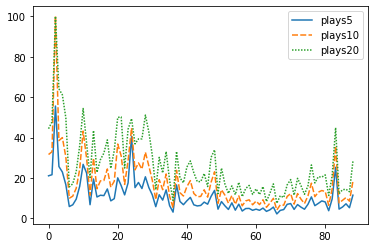

In [66]:
fig, ax = plt.subplots()
sns.lineplot(data=df_top_all_n[["plays5", "plays10", "plays20"]])

---
Graphing the five most played song with their respective **plays per month**.

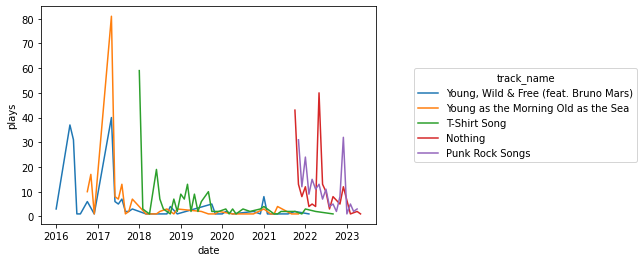

In [67]:
top10 = df["master_metadata_track_name"].value_counts().iloc[:5].index.values
data = df[df["master_metadata_track_name"].isin(top10)]
data = data.groupby([data["ts"].dt.year, data["ts"].dt.month], group_keys=False) \
    ["master_metadata_track_name"].value_counts().to_frame().rename_axis(["year", "month", "track_name"]).reset_index(2) \
    .rename({"master_metadata_track_name":"plays"}, axis=1).reset_index()
data["date"] = pd.to_datetime(data[["year", "month"]].assign(DAY=1))
data = data.drop(["year", "month"], axis=1)


ax = sns.lineplot(data=data, x="date", y="plays", hue="track_name")
sns.move_legend(ax, "center left", bbox_to_anchor=(1.1,0.5))

---
## Ideas
- 💡 for every year, number of songs played for that amount
- top song percentage
- genre breaks
- play peaks / lows
- top genres
- genre percentage
- interpret percentage
- top interpretes
- mean playtime @(month/day/hour)
- skipped
    - time
    - percentage
    - heared again?
    - skipped early/late -> heared again?
    - main genre? -> skipped?
- session recognition?
- song cluster